In [4]:
!pip install dv_processing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 94.6 MB/s eta 0:00:00:00:0100:01


# CODE TO CONVERT CK+ DATA TO DVS SEQUENCES

In [5]:
# ============================================================
# Flat CK+ ➜ DVS events  (symlink-safe version)
# ============================================================

CK_ROOT    = "/kaggle/input/ck-dataset"
OUT_ROOT   = "/kaggle/working/ck_v2e_out"
TMP_ROOT   = "/kaggle/working/_v2e_tmp"
FRAME_RATE = 30
USE_SLOMO  = False

import os, re, glob, shutil, subprocess, pathlib, tempfile, sys
from tqdm.auto import tqdm
os.makedirs(OUT_ROOT, exist_ok=True)
os.makedirs(TMP_ROOT, exist_ok=True)

# 1) lightweight deps
!pip install -q ffmpeg-python imageio[ffmpeg] pims opencv-python-headless tqdm pillow requests gdown

# 2) clone v2e once
WORKING, V2E_DIR = "/kaggle/working", "/kaggle/working/v2e"
if not os.path.isdir(V2E_DIR):
    subprocess.run(["git","clone","--depth","1","https://github.com/SensorsINI/v2e.git",V2E_DIR], check=True)
    subprocess.run(["pip","install","-q","-e",V2E_DIR], check=True)

MODEL_PATH=""
if USE_SLOMO:
    MODEL_PATH=f"{V2E_DIR}/v2e_networks/SuperSloMo39.pth.tar"
    if not os.path.isfile(MODEL_PATH):
        subprocess.run(["gdown","--id","1ETID_4xqLpRBrRo1aOT7Yphs3QqWR_fx","-O",MODEL_PATH], check=True)

# 3) discover sequences (prefix grouping)
pat=re.compile(r"^(S\d+_\d+)_\d+\.png$",re.I)
seqs={}
for emo in sorted(d for d in os.listdir(CK_ROOT) if os.path.isdir(f"{CK_ROOT}/{d}")):
    for png in glob.glob(f"{CK_ROOT}/{emo}/*.png"):
        m=pat.match(os.path.basename(png))
        if not m: continue
        prefix=m.group(1)
        seqs.setdefault((emo,prefix),[]).append(png)

print("✅  Discovered",len(seqs),"sequences.")

# 4) run v2e
records=[]
for (emo,prefix),frames in tqdm(seqs.items(),desc="v2e"):
    if len(frames)<2: continue
    frames.sort(key=lambda x:int(re.search(r"_(\d+)\.png$",x).group(1)))

    tmp_dir=tempfile.mkdtemp(dir=TMP_ROOT)
    for idx,src in enumerate(frames,1):
        dst=f"{tmp_dir}/{idx:08d}.png"
        try:
            os.symlink(src,dst)        # fastest
        except OSError:
            shutil.copy2(src,dst)      # fallback

    out_dir=f"{OUT_ROOT}/{emo}/{prefix}"
    os.makedirs(out_dir,exist_ok=True)

    cmd=["python",f"{V2E_DIR}/v2e.py",
         "-i",tmp_dir,"-o",out_dir,
         "--input_frame_rate",str(FRAME_RATE),
         "--dvs_exposure","duration","0.01",
         "--cutoff_hz","300","--overwrite","--no_preview"]
    cmd+=["--slomo_model",MODEL_PATH] if USE_SLOMO else ["--disable_slomo"]

    run=subprocess.run(cmd,stdout=subprocess.PIPE,stderr=subprocess.PIPE,text=True)
    shutil.rmtree(tmp_dir,ignore_errors=True)

    if run.returncode==0:
        records.append({"emotion":emo,"sequence":prefix,
                        "num_frames":len(frames),"events":out_dir})
    else:
        print(f"\n❌  {emo}/{prefix} failed\n{run.stderr}")

# 5) save CSV
import pandas as pd
if records:
    csv_path=f"{OUT_ROOT}/ck_v2e_summary.csv"
    pd.DataFrame(records).to_csv(csv_path,index=False)
    print(f"\n✅  Converted {len(records)} sequences.")
    print("📄  Summary CSV:",csv_path)
else:
    print("\n⚠️  v2e failed on every sequence.")


✅  Discovered 327 sequences.


v2e:   0%|          | 0/327 [00:00<?, ?it/s]


✅  Converted 327 sequences.
📄  Summary CSV: /kaggle/working/ck_v2e_out/ck_v2e_summary.csv


# AlexNet & AlexNet+LSTM training 

In [19]:
# ============================================================
# CK+ DVS → AlexNet & AlexNet+LSTM training & evaluation
# (with robust zero‑frame filtering)
# ============================================================

# ─── 0) CONFIG ─────────────────────────────────────────────
CSV_PATH    = "/kaggle/working/ck_v2e_out/ck_v2e_summary.csv"
IMG_PATTERN = "dvs_frame_*.png"
BATCH_SIZE  = 32
SEQ_LEN     = 20      # LSTM sees first 20 frames
EPOCHS      = 10
LR          = 1e-5
VAL_SPLIT   = 0.1     # 10% val + 10% test
NUM_WORKERS = 2

import os, glob, random, cv2
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ─── 1) DEPENDENCIES ────────────────────────────────────────
!pip install -q scikit-learn

# ─── 2) LOAD, RENAME & FILTER CSV ──────────────────────────
df = pd.read_csv(CSV_PATH)
# handle old vs new column name
if "events_folder" not in df.columns and "events" in df.columns:
    df = df.rename(columns={"events":"events_folder"})

def count_frames(folder):
    # count PNGs
    pngs = glob.glob(os.path.join(folder, IMG_PATTERN))
    if pngs:
        return len(pngs)
    # else count AVI frames via metadata
    avi = os.path.join(folder, "dvs-video.avi")
    if os.path.isfile(avi):
        cap = cv2.VideoCapture(avi)
        cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return cnt
    return 0

# compute and filter
df["nframes"] = df["events_folder"].apply(count_frames)
df = df[df["nframes"] > 0].reset_index(drop=True)
print(f"Kept {len(df)} sequences with ≥1 frame (out of original).")

# ─── 3) DATASET ─────────────────────────────────────────────
class DVSSequenceDataset(Dataset):
    def __init__(self, df, max_frames, pattern, transform, mode="single"):
        self.df = df.reset_index(drop=True)
        self.max_frames, self.pattern = max_frames, pattern
        self.tf, self.mode = transform, mode
        self.lbl2id = {l:i for i,l in enumerate(sorted(df["emotion"].unique()))}

    def __len__(self):
        return len(self.df)

    def _load_frames(self, folder):
        pngs = sorted(glob.glob(os.path.join(folder, self.pattern)))
        if pngs:
            return [Image.open(p).convert("L") for p in pngs]
        # else fall back to AVI
        avi = os.path.join(folder, "dvs-video.avi")
        cap, imgs = cv2.VideoCapture(avi), []
        ret, frame = cap.read()
        while ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            imgs.append(Image.fromarray(gray))
            ret, frame = cap.read()
        cap.release()
        return imgs

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        frames = self._load_frames(row.events_folder)

        # single‑frame mode: pick densest
        if self.mode == "single":
            densest = max(frames, key=lambda im: np.array(im).sum())
            img = self.tf(densest)
            return img, self.lbl2id[row.emotion]

        # sequence mode: pad/truncate to max_frames
        frames = frames[:self.max_frames]
        while len(frames) < self.max_frames:
            frames.append(frames[-1])
        seq = torch.stack([self.tf(im) for im in frames])  # (T,C,H,W)
        return seq, self.lbl2id[row.emotion]

# transforms (shared)
cxform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# ─── 4) SPLIT & BUILD LOADERS ──────────────────────────────
random.seed(0); torch.manual_seed(0)
n = len(df); n_val = int(n*VAL_SPLIT)
perm = np.random.permutation(n)
idx_tr, idx_val, idx_te = perm[n_val*2:], perm[:n_val], perm[n_val:n_val*2]

train_df, val_df, test_df = df.iloc[idx_tr], df.iloc[idx_val], df.iloc[idx_te]

# datasets
single_train = DVSSequenceDataset(train_df, SEQ_LEN, IMG_PATTERN, cxform, "single")
single_val   = DVSSequenceDataset(val_df,   SEQ_LEN, IMG_PATTERN, cxform, "single")
single_test  = DVSSequenceDataset(test_df,  SEQ_LEN, IMG_PATTERN, cxform, "single")

seq_train = DVSSequenceDataset(train_df, SEQ_LEN, IMG_PATTERN, cxform, "sequence")
seq_val   = DVSSequenceDataset(val_df,   SEQ_LEN, IMG_PATTERN, cxform, "sequence")

# loaders
single_loader = {
    "train": DataLoader(single_train, BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(single_val,   BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
}
seq_loader = {
    "train": DataLoader(seq_train, BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(seq_val,   BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
}

# ─── 5) MODEL A : AlexNet single‐frame ─────────────────────
alex = models.alexnet(weights=None)
alex.features[0] = nn.Conv2d(1,64,11,stride=4,padding=2)
alex.classifier[6] = nn.Linear(4096, len(single_train.lbl2id))
alex.to(device)

# ─── 6) MODEL B : AlexNet + LSTM sequence ──────────────────
class AlexLSTM(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = models.alexnet(weights=None)
        base.features[0] = nn.Conv2d(1,64,11,stride=4,padding=2)
        self.cnn  = nn.Sequential(*list(base.features), base.avgpool)
        self.flat = nn.Flatten()
        self.lstm = nn.LSTM(9216,256,batch_first=True)
        self.head = nn.Linear(256,num_classes)
    def forward(self,x):
        B,T = x.shape[0], x.shape[1]
        feats = self.cnn(x.view(B*T,1,224,224))
        feats = self.flat(feats).view(B,T,-1)
        _,(h,_) = self.lstm(feats)
        return self.head(h.squeeze(0))

alexlstm = AlexLSTM(len(seq_train.lbl2id)).to(device)

# ─── 7) TRAIN/VALID LOOP ───────────────────────────────────
def train_model(model, loaders, name):
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    crit = nn.CrossEntropyLoss()
    hist = {"epoch":[], "tr_loss":[], "tr_acc":[], "val_loss":[], "val_acc":[]}
    for ep in range(1, EPOCHS+1):
        for phase in ("train","val"):
            getattr(model, "train" if phase=="train" else "eval")()
            rl, rc, tot = 0.0, 0, 0
            with torch.set_grad_enabled(phase=="train"):
                for X,y in loaders[phase]:
                    X,y = X.to(device), y.to(device)
                    if phase=="train": opt.zero_grad()
                    out = model(X)
                    loss = crit(out,y)
                    if phase=="train": loss.backward(); opt.step()
                    preds = out.argmax(1)
                    rl  += loss.item()*y.size(0)
                    rc  += (preds==y).sum().item()
                    tot += y.size(0)
            loss_ep = rl/tot; acc_ep = rc/tot
            (hist["tr_loss"] if phase=="train" else hist["val_loss"]).append(loss_ep)
            (hist["tr_acc"]  if phase=="train" else hist["val_acc"]).append(acc_ep)
        hist["epoch"].append(ep)
        print(f"[{name}] Ep{ep}/{EPOCHS} tr_acc {hist['tr_acc'][-1]:.3f} val_acc {hist['val_acc'][-1]:.3f}")
    return hist

hist_single = train_model(alex, single_loader,    "AlexNet")
hist_seq    = train_model(alexlstm, seq_loader,    "AlexNet+LSTM")

# ─── 8) EVALUATION & METRICS ───────────────────────────────
def evaluate(model, dataset):
    model.eval(); yt, yp = [], []
    loader = DataLoader(dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    with torch.no_grad():
        for X,y in loader:
            out = model(X.to(device))
            yt.extend(y.tolist()); yp.extend(out.argmax(1).cpu().tolist())
    acc = accuracy_score(yt,yp)
    pr, rc, f1, _ = precision_recall_fscore_support(yt,yp,average="weighted",zero_division=0)
    return acc, pr, rc, f1

m_s   = evaluate(alex,    single_test)
m_seq = evaluate(alexlstm, seq_test)
print("Single‑frame AlexNet  – acc {:.3f}  prec {:.3f}  rec {:.3f}  f1 {:.3f}".format(*m_s))
print("Seq‑AlexNet+LSTM      – acc {:.3f}  prec {:.3f}  rec {:.3f}  f1 {:.3f}".format(*m_seq))

#


Using device: cuda
Kept 324 sequences with ≥1 frame (out of original).
[AlexNet] Ep1/10 tr_acc 0.177 val_acc 0.094
[AlexNet] Ep2/10 tr_acc 0.231 val_acc 0.062
[AlexNet] Ep3/10 tr_acc 0.250 val_acc 0.000
[AlexNet] Ep4/10 tr_acc 0.238 val_acc 0.000
[AlexNet] Ep5/10 tr_acc 0.238 val_acc 0.000
[AlexNet] Ep6/10 tr_acc 0.238 val_acc 0.000
[AlexNet] Ep7/10 tr_acc 0.238 val_acc 0.000
[AlexNet] Ep8/10 tr_acc 0.246 val_acc 0.000
[AlexNet] Ep9/10 tr_acc 0.269 val_acc 0.000
[AlexNet] Ep10/10 tr_acc 0.254 val_acc 0.000
[AlexNet+LSTM] Ep1/10 tr_acc 0.123 val_acc 0.094
[AlexNet+LSTM] Ep2/10 tr_acc 0.227 val_acc 0.094
[AlexNet+LSTM] Ep3/10 tr_acc 0.227 val_acc 0.094
[AlexNet+LSTM] Ep4/10 tr_acc 0.238 val_acc 0.062
[AlexNet+LSTM] Ep5/10 tr_acc 0.285 val_acc 0.031
[AlexNet+LSTM] Ep6/10 tr_acc 0.281 val_acc 0.000
[AlexNet+LSTM] Ep7/10 tr_acc 0.238 val_acc 0.000
[AlexNet+LSTM] Ep8/10 tr_acc 0.238 val_acc 0.000
[AlexNet+LSTM] Ep9/10 tr_acc 0.235 val_acc 0.031
[AlexNet+LSTM] Ep10/10 tr_acc 0.238 val_acc 0.0

# Transfer‐Learning with ResNet18 & LSTM

Using device: cuda
Kept 324 sequences with ≥1 frame


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[ResNet18] Ep1/20 tr_acc 0.227 val_acc 0.094
[ResNet18] Ep2/20 tr_acc 0.327 val_acc 0.094
[ResNet18] Ep3/20 tr_acc 0.408 val_acc 0.031
[ResNet18] Ep4/20 tr_acc 0.485 val_acc 0.031
[ResNet18] Ep5/20 tr_acc 0.531 val_acc 0.188
[ResNet18] Ep6/20 tr_acc 0.669 val_acc 0.312
[ResNet18] Ep7/20 tr_acc 0.677 val_acc 0.406
[ResNet18] Ep8/20 tr_acc 0.704 val_acc 0.469
[ResNet18] Ep9/20 tr_acc 0.742 val_acc 0.469
[ResNet18] Ep10/20 tr_acc 0.669 val_acc 0.469
[ResNet18] Ep11/20 tr_acc 0.727 val_acc 0.438
[ResNet18] Ep12/20 tr_acc 0.708 val_acc 0.438
[ResNet18] Ep13/20 tr_acc 0.746 val_acc 0.438
[ResNet18] Ep14/20 tr_acc 0.769 val_acc 0.406
[ResNet18] Ep15/20 tr_acc 0.742 val_acc 0.438
[ResNet18] Ep16/20 tr_acc 0.785 val_acc 0.438
[ResNet18] Ep17/20 tr_acc 0.681 val_acc 0.406
[ResNet18] Ep18/20 tr_acc 0.773 val_acc 0.438
[ResNet18] Ep19/20 tr_acc 0.746 val_acc 0.438
[ResNet18] Ep20/20 tr_acc 0.769 val_acc 0.438
[ResNet18+LSTM] Ep1/20 tr_acc 0.212 val_acc 0.156
[ResNet18+LSTM] Ep2/20 tr_acc 0.385 val

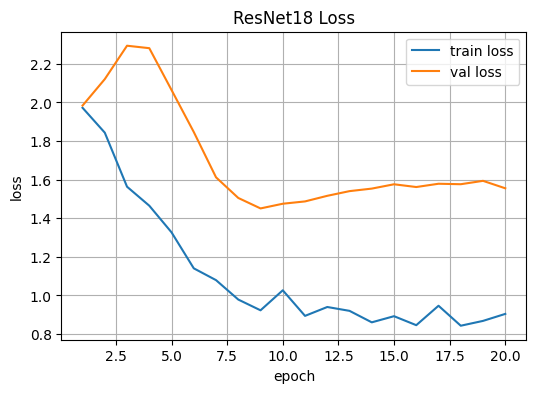

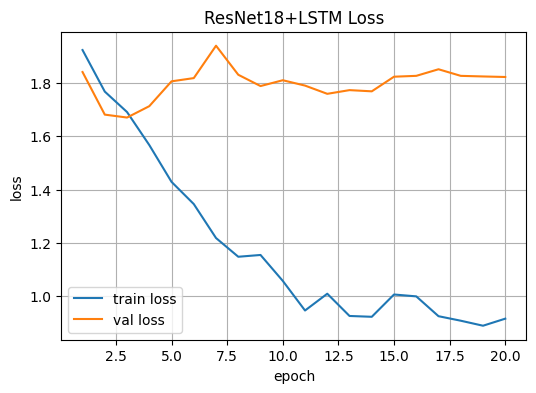

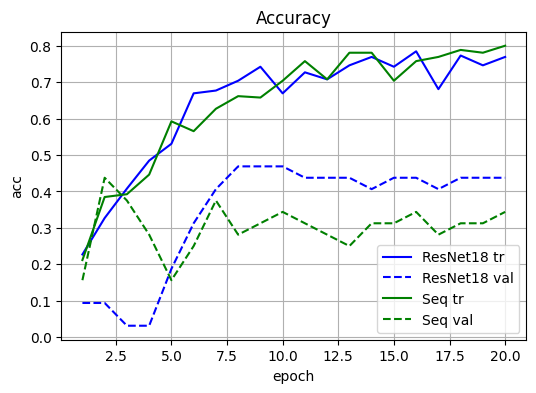

In [21]:
# ============================================================
# CK+ DVS → Transfer‐Learning with ResNet18 & LSTM (fixed train loop)
# ============================================================

# ─── 0) CONFIG ─────────────────────────────────────────────
CSV_PATH     = "/kaggle/working/ck_v2e_out/ck_v2e_summary.csv"
IMG_PATTERN  = "dvs_frame_*.png"
BATCH_SIZE   = 32
SEQ_LEN      = 20
EPOCHS       = 20
LR           = 1e-4
VAL_SPLIT    = 0.1
WEIGHT_DECAY = 1e-5
STEP_SIZE    = 7
GAMMA        = 0.1
NUM_WORKERS  = 4

import os, glob, random, cv2
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ─── 1) DEPENDENCIES ────────────────────────────────────────
!pip install -q scikit-learn

# ─── 2) LOAD, RENAME & FILTER CSV ──────────────────────────
df = pd.read_csv(CSV_PATH)
if "events_folder" not in df.columns and "events" in df.columns:
    df = df.rename(columns={"events":"events_folder"})

def count_frames(folder):
    pngs = glob.glob(os.path.join(folder, IMG_PATTERN))
    if pngs:
        return len(pngs)
    avi = os.path.join(folder, "dvs-video.avi")
    if os.path.isfile(avi):
        cap = cv2.VideoCapture(avi)
        cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return cnt
    return 0

df["nframes"] = df["events_folder"].apply(count_frames)
df = df[df["nframes"]>0].reset_index(drop=True)
print(f"Kept {len(df)} sequences with ≥1 frame")

# ─── 3) SPLIT ───────────────────────────────────────────────
random.seed(0); torch.manual_seed(0)
n = len(df); n_val = int(n*VAL_SPLIT)
perm = np.random.permutation(n)
idx_tr, idx_val, idx_te = perm[n_val*2:], perm[:n_val], perm[n_val:n_val*2]
train_df, val_df, test_df = df.iloc[idx_tr], df.iloc[idx_val], df.iloc[idx_te]

# ─── 4) DATASET ─────────────────────────────────────────────
class DVSSequenceDataset(Dataset):
    def __init__(self, df, max_frames, pattern, tfm, mode="single"):
        self.df = df.reset_index(drop=True)
        self.max_frames, self.pattern = max_frames, pattern
        self.tf, self.mode = tfm, mode
        self.lbl2id = {l:i for i,l in enumerate(sorted(df["emotion"].unique()))}
    def __len__(self): return len(self.df)
    def _load_frames(self, folder):
        pngs = sorted(glob.glob(os.path.join(folder, self.pattern)))
        if pngs:
            return [Image.open(p).convert("L") for p in pngs]
        imgs, cap = [], cv2.VideoCapture(os.path.join(folder, "dvs-video.avi"))
        ret,frame = cap.read()
        while ret:
            imgs.append(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)))
            ret,frame = cap.read()
        cap.release()
        return imgs
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        frames = self._load_frames(row.events_folder)
        if self.mode=="single":
            densest = max(frames, key=lambda im: np.array(im).sum())
            return self.tf(densest), self.lbl2id[row.emotion]
        # sequence mode
        frames = frames[:self.max_frames]
        while len(frames)<self.max_frames:
            frames.append(frames[-1])
        seq = torch.stack([self.tf(f) for f in frames])
        return seq, self.lbl2id[row.emotion]

# ─── 5) TRANSFORMS ──────────────────────────────────────────
train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

# ─── 6) DATALOADERS & SAMPLER ─────────────────────────────
counts = train_df['emotion'].value_counts().sort_index()
class_weights = 1.0/counts
sample_weights = train_df['emotion'].map(class_weights).values
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

single_train = DVSSequenceDataset(train_df, SEQ_LEN, IMG_PATTERN, train_tf, "single")
single_val   = DVSSequenceDataset(val_df,   SEQ_LEN, IMG_PATTERN, val_tf,   "single")
single_test  = DVSSequenceDataset(test_df,  SEQ_LEN, IMG_PATTERN, val_tf,   "single")
seq_train    = DVSSequenceDataset(train_df, SEQ_LEN, IMG_PATTERN, train_tf, "sequence")
seq_val      = DVSSequenceDataset(val_df,   SEQ_LEN, IMG_PATTERN, val_tf,   "sequence")

single_loader = {
    "train": DataLoader(single_train, BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(single_val,   BATCH_SIZE, shuffle=False,     num_workers=NUM_WORKERS, pin_memory=True)
}
seq_loader = {
    "train": DataLoader(seq_train,    BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(seq_val,      BATCH_SIZE, shuffle=False,     num_workers=NUM_WORKERS, pin_memory=True)
}

# ─── 7) MODEL A: ResNet‑18 single‑frame ─────────────────────
res = models.resnet18(pretrained=True)
w   = res.conv1.weight.data
res.conv1 = nn.Conv2d(1,64,7,2,3,bias=False)
res.conv1.weight.data = w.mean(1,keepdim=True)
res.fc = nn.Linear(res.fc.in_features, len(single_train.lbl2id))
model_s = res.to(device)

# ─── 8) MODEL B: ResNet‑18 + LSTM ──────────────────────────
class ResLSTM(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        trunk = nn.Sequential(*list(backbone.children())[:-1])
        self.trunk, self.lstm, self.head = trunk, nn.LSTM(512,256,batch_first=True), nn.Linear(256,num_classes)
    def forward(self,x):
        B,T = x.size(0), x.size(1)
        feats = self.trunk(x.view(B*T,1,224,224)).view(B,T,-1)
        _,(h,_) = self.lstm(feats)
        return self.head(h.squeeze(0))

model_seq = ResLSTM(res, len(seq_train.lbl2id)).to(device)

# ─── 9) OPTIM & SCHED ──────────────────────────────────────
opt_s   = torch.optim.Adam(model_s.parameters(),   lr=LR, weight_decay=WEIGHT_DECAY)
opt_seq = torch.optim.Adam(model_seq.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sch_s   = torch.optim.lr_scheduler.StepLR(opt_s,   step_size=STEP_SIZE, gamma=GAMMA)
sch_seq = torch.optim.lr_scheduler.StepLR(opt_seq, step_size=STEP_SIZE, gamma=GAMMA)
crit    = nn.CrossEntropyLoss()

# ─── 10) TRAIN/VALID FUNCTION (FIXED) ─────────────────────
def train_model(model, loaders, optimizer, scheduler, name):
    history = {"epoch":[], "tr_loss":[], "tr_acc":[], "val_loss":[], "val_acc":[]}
    for ep in range(1, EPOCHS+1):
        for phase in ("train","val"):
            prefix = "tr" if phase=="train" else "val"
            getattr(model, "train" if phase=="train" else "eval")()
            rl, rc, tot = 0.0,0,0
            with torch.set_grad_enabled(phase=="train"):
                for X,y in loaders[phase]:
                    X,y = X.to(device), y.to(device)
                    if phase=="train": optimizer.zero_grad()
                    out = model(X)
                    loss = crit(out,y)
                    if phase=="train": loss.backward(); optimizer.step()
                    preds = out.argmax(1)
                    rl  += loss.item()*y.size(0)
                    rc  += (preds==y).sum().item()
                    tot += y.size(0)
            history[f"{prefix}_loss"].append(rl/tot)
            history[f"{prefix}_acc"].append(rc/tot)
        scheduler.step()
        history["epoch"].append(ep)
        print(f"[{name}] Ep{ep}/{EPOCHS} tr_acc {history['tr_acc'][-1]:.3f} val_acc {history['val_acc'][-1]:.3f}")
    return history

# ─── 11) TRAIN ─────────────────────────────────────────────
hist_s   = train_model(model_s,   single_loader, opt_s,   sch_s,   "ResNet18")
hist_seq = train_model(model_seq,  seq_loader,    opt_seq, sch_seq, "ResNet18+LSTM")

# ─── 12) EVAL & METRICS ────────────────────────────────────
def evaluate(model, dataset):
    model.eval(); yt,yp = [],[]
    loader = DataLoader(dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    with torch.no_grad():
        for X,y in loader:
            out = model(X.to(device))
            yt += y.tolist(); yp += out.argmax(1).cpu().tolist()
    acc  = accuracy_score(yt,yp)
    pr,rc,f1,_ = precision_recall_fscore_support(yt,yp,average="weighted",zero_division=0)
    return acc,pr,rc,f1

m_s   = evaluate(model_s,  single_test)
m_seq = evaluate(model_seq, seq_test)
print(f"\nSingle ResNet18 — acc {m_s[0]:.3f} prec {m_s[1]:.3f} rec {m_s[2]:.3f} f1 {m_s[3]:.3f}")
print(f"Seq ResNet18+LSTM — acc {m_seq[0]:.3f} prec {m_seq[1]:.3f} rec {m_seq[2]:.3f} f1 {m_seq[3]:.3f}")

# ─── 13) PLOT ───────────────────────────────────────────────
def plot_curves(h, title):
    plt.figure(figsize=(6,4))
    plt.plot(h["epoch"], h["tr_loss"], label="train loss")
    plt.plot(h["epoch"], h["val_loss"], label="val loss")
    plt.title(f"{title} Loss"); plt.xlabel("epoch"); plt.ylabel("loss")
    plt.legend(); plt.grid(True); plt.show()

plot_curves(hist_s,   "ResNet18")
plot_curves(hist_seq,"ResNet18+LSTM")

plt.figure(figsize=(6,4))
plt.plot(hist_s["epoch"],   hist_s["tr_acc"],   "b-",  label="ResNet18 tr")
plt.plot(hist_s["epoch"],   hist_s["val_acc"],  "b--", label="ResNet18 val")
plt.plot(hist_seq["epoch"], hist_seq["tr_acc"], "g-",  label="Seq tr")
plt.plot(hist_seq["epoch"], hist_seq["val_acc"],"g--", label="Seq val")
plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc")
plt.legend(); plt.grid(True); plt.show()


# ResNet18 and Lstm 

Using device: cuda
Kept 324 sequences with ≥1 frame


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[ResNet18] Ep 1/20 — tr_acc 0.123  val_acc 0.062
[ResNet18] Ep 2/20 — tr_acc 0.188  val_acc 0.062
[ResNet18] Ep 3/20 — tr_acc 0.181  val_acc 0.000
[ResNet18] Ep 4/20 — tr_acc 0.162  val_acc 0.250
[ResNet18] Ep 5/20 — tr_acc 0.173  val_acc 0.188
[ResNet18] Ep 6/20 — tr_acc 0.223  val_acc 0.188
[ResNet18] Ep 7/20 — tr_acc 0.242  val_acc 0.219
[ResNet18] Ep 8/20 — tr_acc 0.235  val_acc 0.312
[ResNet18] Ep 9/20 — tr_acc 0.296  val_acc 0.281
[ResNet18] Ep 10/20 — tr_acc 0.223  val_acc 0.312
[ResNet18] Ep 11/20 — tr_acc 0.285  val_acc 0.250
[ResNet18] Ep 12/20 — tr_acc 0.362  val_acc 0.188
[ResNet18] Ep 13/20 — tr_acc 0.335  val_acc 0.188
[ResNet18] Ep 14/20 — tr_acc 0.269  val_acc 0.250
[ResNet18] Ep 15/20 — tr_acc 0.373  val_acc 0.281
[ResNet18] Ep 16/20 — tr_acc 0.396  val_acc 0.281
[ResNet18] Ep 17/20 — tr_acc 0.304  val_acc 0.250
[ResNet18] Ep 18/20 — tr_acc 0.338  val_acc 0.219
[ResNet18] Ep 19/20 — tr_acc 0.392  val_acc 0.219
[ResNet18] Ep 20/20 — tr_acc 0.377  val_acc 0.250
[ResNet18

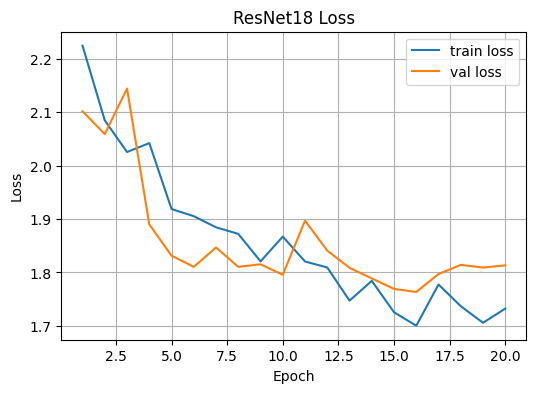

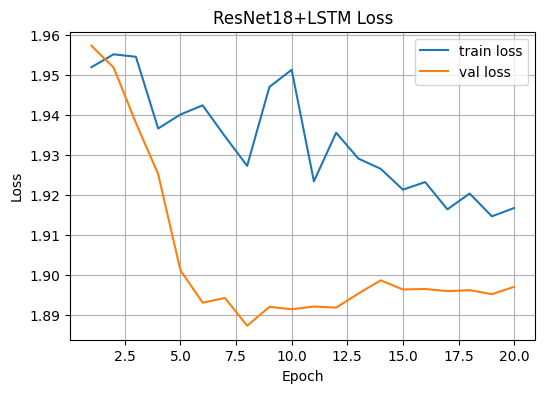

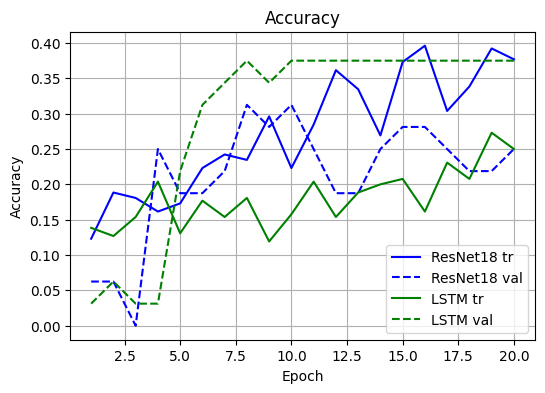

In [23]:
# ============================================================
# CK+ DVS → Fine‑tuned ResNet18 & LSTM with OneCycleLR & Augmentations
# ============================================================

# ─── 0) CONFIG ─────────────────────────────────────────────
CSV_PATH     = "/kaggle/working/ck_v2e_out/ck_v2e_summary.csv"
IMG_PATTERN  = "dvs_frame_*.png"
BATCH_SIZE   = 32
SEQ_LEN      = 20
EPOCHS       = 20
LR           = 1e-3               # peak LR for OneCycleLR
VAL_SPLIT    = 0.1
WEIGHT_DECAY = 1e-5
NUM_WORKERS  = 4

import os, glob, random, cv2
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ─── 1) LOAD & FILTER CSV ───────────────────────────────────
df = pd.read_csv(CSV_PATH)
if "events_folder" not in df.columns and "events" in df.columns:
    df = df.rename(columns={"events":"events_folder"})

def count_frames(folder):
    pngs = glob.glob(os.path.join(folder, IMG_PATTERN))
    if pngs: return len(pngs)
    avi = os.path.join(folder, "dvs-video.avi")
    if os.path.isfile(avi):
        cap = cv2.VideoCapture(avi)
        cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return cnt
    return 0

df["nframes"] = df["events_folder"].apply(count_frames)
df = df[df["nframes"]>0].reset_index(drop=True)
print(f"Kept {len(df)} sequences with ≥1 frame")

# ─── 2) SPLIT ───────────────────────────────────────────────
random.seed(0); torch.manual_seed(0)
n = len(df); n_val = int(n * VAL_SPLIT)
perm = np.random.permutation(n)
idx_tr, idx_val, idx_te = perm[n_val*2:], perm[:n_val], perm[n_val:n_val*2]
train_df, val_df, test_df = df.iloc[idx_tr], df.iloc[idx_val], df.iloc[idx_te]

# ─── 3) DATASET CLASS ──────────────────────────────────────
class DVSSequenceDataset(Dataset):
    def __init__(self, df, max_frames, pattern, tfm, mode="single"):
        self.df = df.reset_index(drop=True)
        self.max_frames, self.pattern = max_frames, pattern
        self.tf, self.mode = tfm, mode
        self.lbl2id = {l:i for i,l in enumerate(sorted(df["emotion"].unique()))}
    def __len__(self): return len(self.df)
    def _load_frames(self, folder):
        pngs = sorted(glob.glob(os.path.join(folder, self.pattern)))
        if pngs:
            return [Image.open(p).convert("L") for p in pngs]
        imgs, cap = [], cv2.VideoCapture(os.path.join(folder, "dvs-video.avi"))
        ret, frame = cap.read()
        while ret:
            imgs.append(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)))
            ret, frame = cap.read()
        cap.release()
        return imgs
    def __getitem__(self, idx):
        row    = self.df.iloc[idx]
        frames = self._load_frames(row.events_folder)
        if self.mode=="single":
            densest = max(frames, key=lambda im: np.array(im).sum())
            return self.tf(densest), self.lbl2id[row.emotion]
        # sequence mode
        frames = frames[:self.max_frames]
        while len(frames) < self.max_frames:
            frames.append(frames[-1])
        seq = torch.stack([self.tf(f) for f in frames])
        return seq, self.lbl2id[row.emotion]

# ─── 4) AUGMENTED TRANSFORMS ───────────────────────────────
train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5)
])
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# ─── 5) DATALOADERS & SAMPLER ─────────────────────────────
counts         = train_df['emotion'].value_counts().sort_index()
class_weights  = 1.0 / counts
sample_weights = train_df['emotion'].map(class_weights).values
sampler        = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

single_train = DVSSequenceDataset(train_df, SEQ_LEN, IMG_PATTERN, train_tf, "single")
single_val   = DVSSequenceDataset(val_df,   SEQ_LEN, IMG_PATTERN, val_tf,   "single")
single_test  = DVSSequenceDataset(test_df,  SEQ_LEN, IMG_PATTERN, val_tf,   "single")
seq_train    = DVSSequenceDataset(train_df, SEQ_LEN, IMG_PATTERN, train_tf, "sequence")
seq_val      = DVSSequenceDataset(val_df,   SEQ_LEN, IMG_PATTERN, val_tf,   "sequence")

single_loader = {
    "train": DataLoader(single_train, BATCH_SIZE, sampler=sampler,                num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(single_val,   BATCH_SIZE, shuffle=False,                 num_workers=NUM_WORKERS, pin_memory=True)
}
seq_loader = {
    "train": DataLoader(seq_train,    BATCH_SIZE, sampler=sampler,                num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(seq_val,      BATCH_SIZE, shuffle=False,                 num_workers=NUM_WORKERS, pin_memory=True)
}

# ─── 6) BACKBONE & MODELS ─────────────────────────────────
res = models.resnet18(pretrained=True)
w   = res.conv1.weight.data
res.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
res.conv1.weight.data = w.mean(1, keepdim=True)
res.fc = nn.Linear(res.fc.in_features, len(single_train.lbl2id))
model_s = res.to(device)

class ResLSTM(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        trunk = nn.Sequential(*list(backbone.children())[:-1])
        self.trunk = trunk
        self.lstm  = nn.LSTM(512, 256, batch_first=True)
        self.head  = nn.Linear(256, num_classes)
    def forward(self, x):
        B, T = x.shape[:2]
        feats = self.trunk(x.view(B*T, 1, 224, 224)).view(B, T, -1)
        _, (h, _) = self.lstm(feats)
        return self.head(h.squeeze(0))

model_seq = ResLSTM(res, len(seq_train.lbl2id)).to(device)

# ─── 7) OPTIMIZER, SCHEDULER & LOSS ────────────────────────
opt_s   = torch.optim.SGD(model_s.parameters(),   lr=LR, momentum=0.9, weight_decay=WEIGHT_DECAY)
opt_seq = torch.optim.SGD(model_seq.parameters(), lr=LR, momentum=0.9, weight_decay=WEIGHT_DECAY)
total_steps = len(single_loader["train"]) * EPOCHS
sched_s   = torch.optim.lr_scheduler.OneCycleLR(opt_s,   max_lr=LR, total_steps=total_steps)
sched_seq = torch.optim.lr_scheduler.OneCycleLR(opt_seq, max_lr=LR, total_steps=total_steps)
crit      = nn.CrossEntropyLoss(label_smoothing=0.1)

# ─── 8) TRAIN/VALIDATE FUNCTION (fixed) ──────────────────
def train_model(model, loaders, optimizer, scheduler, name):
    history = {"epoch":[], "tr_loss":[], "tr_acc":[], "val_loss":[], "val_acc":[]}
    for ep in range(1, EPOCHS+1):
        for phase in ("train","val"):
            if phase=="train":
                model.train()
            else:
                model.eval()

            rl = rc = tot = 0
            with torch.set_grad_enabled(phase=="train"):
                for X, y in loaders[phase]:
                    X, y = X.to(device), y.to(device)
                    if phase=="train":
                        optimizer.zero_grad()
                    out  = model(X)
                    loss = crit(out, y)
                    if phase=="train":
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                    preds = out.argmax(1)
                    rl  += loss.item() * y.size(0)
                    rc  += (preds == y).sum().item()
                    tot += y.size(0)

            key = "tr" if phase=="train" else "val"
            history[f"{key}_loss"].append(rl/tot)
            history[f"{key}_acc"].append(rc/tot)

        history["epoch"].append(ep)
        print(f"[{name}] Ep {ep}/{EPOCHS} — tr_acc {history['tr_acc'][-1]:.3f}  val_acc {history['val_acc'][-1]:.3f}")

    return history

# ─── 9) RUN TRAINING ───────────────────────────────────────
hist_s   = train_model(model_s,   single_loader, opt_s,   sched_s,   "ResNet18")
hist_seq = train_model(model_seq,  seq_loader,    opt_seq, sched_seq, "ResNet18+LSTM")

# ─── 10) EVALUATION & METRICS ──────────────────────────────
def evaluate(model, dataset):
    model.eval()
    yt = []; yp = []
    loader = DataLoader(dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    with torch.no_grad():
        for X, y in loader:
            out = model(X.to(device))
            yt.extend(y.tolist())
            yp.extend(out.argmax(1).cpu().tolist())
    acc    = accuracy_score(yt, yp)
    prec, rec, f1, _ = precision_recall_fscore_support(yt, yp, average="weighted", zero_division=0)
    return acc, prec, rec, f1

m_s   = evaluate(model_s,  single_test)
m_seq = evaluate(model_seq, seq_test)
print(f"\nResNet18 single — acc {m_s[0]:.3f}  prec {m_s[1]:.3f}  rec {m_s[2]:.3f}  f1 {m_s[3]:.3f}")
print(f"ResNet18+LSTM — acc {m_seq[0]:.3f}  prec {m_seq[1]:.3f}  rec {m_seq[2]:.3f}  f1 {m_seq[3]:.3f}")

# ─── 11) PLOT TRAIN/VAL CURVES ──────────────────────────────
def plot_curves(h, title):
    plt.figure(figsize=(6,4))
    plt.plot(h["epoch"], h["tr_loss"], label="train loss")
    plt.plot(h["epoch"], h["val_loss"], label="val loss")
    plt.title(f"{title} Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(True); plt.show()

plot_curves(hist_s,   "ResNet18")
plot_curves(hist_seq, "ResNet18+LSTM")

plt.figure(figsize=(6,4))
plt.plot(hist_s["epoch"],   hist_s["tr_acc"],   "b-",  label="ResNet18 tr")
plt.plot(hist_s["epoch"],   hist_s["val_acc"],  "b--", label="ResNet18 val")
plt.plot(hist_seq["epoch"], hist_seq["tr_acc"], "g-",  label="LSTM tr")
plt.plot(hist_seq["epoch"], hist_seq["val_acc"],"g--", label="LSTM val")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.show()


# asynet

In [45]:
# CK+ DVS → AsyNet‑II Sparse Backbone Training & Evaluation on Kaggle
# ============================================================

"""
Environment setup (if using conda shell outside Kaggle):
  conda create -n asynet python=3.7
  conda activate asynet
"""

# ─── 0) CLONE & INSTALL ASYNET‑II DEPENDENCIES ─────────────
# Run this cell first in your Kaggle notebook

# 1) Clone the AsyNet‑II repository via SSH
if not os.path.isdir('rpg_asynet'):
    get_ipython().system('git clone git@github.com:uzh-rpg/rpg_asynet.git')
# Enter the directory
get_ipython().system('cd rpg_asynet')


#get_ipython().system('pip install -q \
 # absl-py==0.9.0 backcall==0.1.0 cachetools==4.0.0 certifi==2019.11.28 chardet==3.0.4 cycler==0.10.0 data==0.4 decorator==4.4.1 funcsigs==1.0.2 future==0.18.2 google-auth==1.11.0 google-auth-oauthlib==0.4.1 grpcio==1.26.0 idna==2.8 ipython==7.13.0 ipython-genutils==0.2.0 jedi==0.16.0 kiwisolver==1.1.0 line-profiler==3.0.2 Markdown==3.2 matplotlib==3.1.3 numpy==1.18.1 oauthlib==3.1.0 opencv-python==4.2.0.32 parso==0.6.2 pexpect==4.8.0 pickleshare==0.7.5 Pillow==8.1.2 prompt-toolkit==3.0.3 protobuf==3.11.3 ptyprocess==0.6.0 pyasn1==0.4.8 pyasn1-modules==0.2.8 pybind11==2.4.3 Pygments==2.5.2 pyparsing==2.4.6 python-dateutil==2.8.1 pytz==2019.3 PyYAML==5.3 requests==2.22.0 requests-oauthlib==1.3.0 shutilwhich==1.1.0 six==1.14.0 snakeviz==2.0.1 tempdir==0.7.1 tensorboard==2.1.0 torch==1.4.0 torchvision==0.5.0 tornado==6.0.3 tqdm==4.42.1 traitlets==4.3.3 urllib3==1.25.8 wcwidth==0.1.8 Werkzeug==1.0.0')
# 2) Install AsyNet‑II Python requirements manually (avoid SSH git URLs)
#    We replace `-r requirements.txt` since it contains git+ssh entries.
get_ipython().system('pip install -q torch torchvision numpy scipy matplotlib pyyaml scikit-learn tqdm')


# 3) Clone and install SparseConvNet v0.2
if not os.path.isdir('SparseConvNet'):
    get_ipython().system('git clone https://github.com/facebookresearch/SparseConvNet.git')
get_ipython().system('cd SparseConvNet && python setup.py install --user && cd ..')




# 4) Install C++ and Python bindings for event representation tool
get_ipython().system('pip install -q /kaggle/working/rpg_asynet/event_representation_tool/')



#if not os.path.isdir('rpg_asynet/async_sparse_py/include/eigen'):
  #  !git clone https://gitlab.com/libeigen/eigen.git rpg_asynet/async_sparse_py/include/eigen


# 6) Install pybind11 via conda-forge (if available) or pip
# conda install -y -c conda-forge pybind11
#get_ipython().system('pip install -q pybind11')

# 7) Install the AsyNet‑II Python package (editable) from the local clone
get_ipython().system('pip install -q -e /kaggle/working/rpg_asynet/async_sparse_py/')
# ─── 1) IMPORTS & CONFIG ────────────────────────────────────
import os, glob, random
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader        # ← ensure Dataset is imported
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Add AsyNet‑II code to path
#sys.path.insert(0, os.path.join(os.getcwd(), 'rpg_asynet'))
# Import SparseVGG and dataset factory
from models.asyn_sparse_vgg import asynSparseVGG
from dataloader.dataset import getDataloader

DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)# ─── 1) IMPORTS & CONFIG ────────────────────────────────────
import os, glob, random
import numpy as np, pandas as pd
# patch deprecated np.int
np.int = int

from PIL import Image
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# AsyNet‑II import
import sys
sys.path.insert(0, "/kaggle/working/rpg_asynet")
from models.asyn_sparse_vgg import asynSparseVGG

DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_PATH   = "/kaggle/input/ck-v2e-out"
CSV_PATH    = "/kaggle/input/ck-v2e-out/kaggle/working/ck_v2e_out/ck_v2e_summary.csv"
IMG_PATTERN = "dvs_frame_*.png"
BATCH_SIZE  = 8
EPOCHS      = 20
LR          = 1e-5

print("Using device:", DEVICE)

# ─── 2) GLOBAL LABEL MAP ────────────────────────────────────
df_full  = pd.read_csv(CSV_PATH)
emotions = sorted(df_full["emotion"].unique())
lbl2id   = {emo:i for i, emo in enumerate(emotions)}
print("Classes:", lbl2id)

# ─── 3) THE CK+→DVS DATASET ────────────────────────────────
class CKPlusDataset(Dataset):
    def __init__(self, csv_path, base_path, split_idxs, lbl2id):
        df    = pd.read_csv(csv_path).reset_index(drop=True)
        rows  = []
        for i in split_idxs:
            raw    = df.at[i,"events"].lstrip("/")
            folder = os.path.join(base_path, raw)
            if glob.glob(os.path.join(folder, IMG_PATTERN)) \
               or os.path.isfile(os.path.join(folder,"dvs-video.avi")):
                rows.append((i,folder))
        self.rows   = rows
        self.df     = df
        self.lbl2id = lbl2id

    def __len__(self): return len(self.rows)

    def __getitem__(self, idx):
        orig_idx, folder = self.rows[idx]
        evs = []

        # try PNGs
        pngs = sorted(glob.glob(os.path.join(folder, IMG_PATTERN)))
        if pngs:
            for t,p in enumerate(pngs):
                img = np.array(Image.open(p).convert("L"))
                ys,xs = np.nonzero(img)
                if xs.size:
                    ts  = np.full_like(xs, t, dtype=np.float32)
                    pol = np.where(img[ys,xs]>0,1.0,-1.0).astype(np.float32)
                    evs.append(np.stack([xs,ys,ts,pol],axis=1))
        else:
            # fallback to AVI
            import cv2
            cap = cv2.VideoCapture(os.path.join(folder,"dvs-video.avi"))
            t = 0
            while True:
                ret,fr = cap.read()
                if not ret: break
                gray = cv2.cvtColor(fr,cv2.COLOR_BGR2GRAY)
                ys,xs = np.nonzero(gray)
                if xs.size:
                    ts  = np.full_like(xs,t,dtype=np.float32)
                    pol = np.where(gray[ys,xs]>0,1.0,-1.0).astype(np.float32)
                    evs.append(np.stack([xs,ys,ts,pol],axis=1))
                t+=1
            cap.release()

        if not evs:
            evs = [np.zeros((1,4),dtype=np.float32)]

        events = torch.from_numpy(np.vstack(evs).astype(np.float32))
        label  = torch.tensor(self.lbl2id[self.df.at[orig_idx,"emotion"]],
                              dtype=torch.long)
        return events, label

# ─── 4) SPLIT & DATALOADERS ────────────────────────────────
n       = len(df_full)
idxs    = np.arange(n)
np.random.seed(0); np.random.shuffle(idxs)
n_val   = int(0.1 * n)
train_i = idxs[n_val*2:]
val_i   = idxs[:n_val]
test_i  = idxs[n_val:n_val*2]

train_ds = CKPlusDataset(CSV_PATH, BASE_PATH, train_i, lbl2id)
val_ds   = CKPlusDataset(CSV_PATH, BASE_PATH, val_i,   lbl2id)
test_ds  = CKPlusDataset(CSV_PATH, BASE_PATH, test_i,  lbl2id)
print("Dataset sizes:", len(train_ds), len(val_ds), len(test_ds))

def ck_collate(batch):
    evs, lbs = zip(*batch)
    return torch.cat(evs,0), torch.stack(lbs)

train_loader = DataLoader(train_ds,  batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True,
                          collate_fn=ck_collate)
val_loader   = DataLoader(val_ds,    batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True,
                          collate_fn=ck_collate)
test_loader  = DataLoader(test_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True,
                          collate_fn=ck_collate)

# ─── 5) MODEL, OPT & SCHEDULER ─────────────────────────────
model = asynSparseVGG(nr_classes=len(emotions),
                      input_channels=2,
                      device=DEVICE)

# collect only the sparse‐conv params
params = []
for L in model.asyn_layers:
    if hasattr(L, "parameters"):
        params += list(L.parameters())

opt   = torch.optim.Adam(params, lr=LR)
steps = len(train_loader) * EPOCHS
sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=LR, total_steps=steps)
crit  = nn.CrossEntropyLoss()

def set_asynet_mode(net, train_mode:bool):
    for L in net.asyn_layers:
        if hasattr(L, "train"):
            L.train(train_mode)

# ─── safe_forward HELPER ───────────────────────────────────
def safe_forward(model, ups, fm):
    """
    Wraps model.forward((ups,fm)).
    On that device‐mismatch error, retries on CPU then moves back to DEVICE.
    """
    try:
        return model.forward((ups,fm))
    except RuntimeError as err:
        msg = str(err)
        if "indices should be either on cpu" in msg:
            # retry on CPU
            ups_c = ups.cpu()
            fm_c  = fm.cpu()
            out_c = model.forward((ups_c,fm_c))
            return (out_c[0].to(DEVICE), out_c[1].to(DEVICE))
        else:
            raise




Using device: cuda
Classes: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sadness': 5, 'surprise': 6}
Dataset sizes: 263 32 32


# RestNet 50 and Transformer

In [59]:
# ─── 0) Install / Imports ─────────────────────────────────────────
# !pip install torch torchvision  # if not already installed

import os, glob
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# ─── 1) CONFIGURATION ─────────────────────────────────────────────
BASE_PATH = "/kaggle/input/ck-v2e-out"
CSV_PATH  = os.path.join(BASE_PATH, "kaggle/working/ck_v2e_out/ck_v2e_summary.csv")
BATCH_SIZE = 8
EPOCHS     = 20
LR         = 1e-5
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_BINS = 5               # # time‐slices
HEIGHT   = 180             # DVS sensor height
WIDTH    = 240             # DVS sensor width

print("Using device:", DEVICE)

# ─── 2) DATASET ───────────────────────────────────────────────────
class CKPlusVoxelDataset(Dataset):
    def __init__(self, csv_path, base_path, split_idxs, lbl2id,
                 num_bins=8, H=180, W=240, img_pattern="dvs_frame_*.png"):
        df = pd.read_csv(csv_path).reset_index(drop=True)
        self.df      = df.loc[split_idxs].reset_index(drop=True)
        self.base    = base_path
        self.lbl2id  = lbl2id
        self.num_bins = num_bins
        self.H, self.W = H, W
        self.img_pattern = img_pattern

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        rel = r["events"].lstrip("/")                    # "/anger/S011_004"
        folder = os.path.join(self.base, rel)             # .../ck-v2e-out/anger/S011_004

        # 1) Load per‐pixel events from PNGs (or AVI fallback)
        arrs = []
        pngs = sorted(glob.glob(os.path.join(folder, self.img_pattern)))
        if pngs:
            for t,p in enumerate(pngs):
                im = np.array(Image.open(p).convert("L"))
                ys,xs = np.nonzero(im)
                if xs.size:
                    ts  = np.full_like(xs, t, dtype=np.int64)
                    pol = (im[ys,xs] > 0).astype(np.int64)
                    arrs.append(np.stack([xs, ys, ts, pol], axis=1))
        else:
            import cv2
            cap = cv2.VideoCapture(os.path.join(folder,"dvs-video.avi"))
            t = 0
            while True:
                ret,frame = cap.read()
                if not ret: break
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                ys,xs = np.nonzero(gray)
                if xs.size:
                    ts  = np.full_like(xs, t, dtype=np.int64)
                    pol = (gray[ys,xs] > 0).astype(np.int64)
                    arrs.append(np.stack([xs, ys, ts, pol], axis=1))
                t += 1
            cap.release()

        if not arrs:
            arrs = [np.zeros((1,4),dtype=np.int64)]
        ev = np.vstack(arrs)  # shape (N_events,4)

        # 2) Bin into a (B,2,H,W) “voxel grid”
        voxel = np.zeros((self.num_bins, 2, self.H, self.W), dtype=np.float32)
        max_t = int(ev[:,2].max()) + 1
        edges = np.linspace(0, max_t, self.num_bins+1)
        for x,y,t,pol in ev:
            b = np.searchsorted(edges, t, side="right") - 1
            b = int(np.clip(b, 0, self.num_bins-1))
            voxel[b, pol, y, x] += 1.0

        voxel = torch.from_numpy(voxel)  # (B,2,H,W)
        lbl   = torch.tensor(self.lbl2id[r["emotion"]], dtype=torch.long)
        return voxel, lbl

# ─── 3) SPLIT & DATALOADERS ────────────────────────────────────────
df_full  = pd.read_csv(CSV_PATH)
emotions = sorted(df_full["emotion"].unique())
lbl2id   = {emo:i for i,emo in enumerate(emotions)}

n  = len(df_full)
idx = np.arange(n)
np.random.seed(0); np.random.shuffle(idx)
n_val = int(0.1 * n)
train_idx = idx[n_val*2:]
val_idx   = idx[:n_val]
test_idx  = idx[n_val:n_val*2]

train_ds = CKPlusVoxelDataset(CSV_PATH, BASE_PATH, train_idx, lbl2id,
                              num_bins=NUM_BINS, H=HEIGHT, W=WIDTH)
val_ds   = CKPlusVoxelDataset(CSV_PATH, BASE_PATH, val_idx,   lbl2id,
                              num_bins=NUM_BINS, H=HEIGHT, W=WIDTH)
test_ds  = CKPlusVoxelDataset(CSV_PATH, BASE_PATH, test_idx,  lbl2id,
                              num_bins=NUM_BINS, H=HEIGHT, W=WIDTH)

print("Dataset sizes:", len(train_ds), len(val_ds), len(test_ds))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True)

# ─── 4) MODEL DEFINITION ───────────────────────────────────────────
class ResNetTransformer(nn.Module):
    def __init__(self, num_classes, num_bins):
        super().__init__()
        # 1) Pretrained ResNet50 as spatial feature extractor
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        # adapt first conv to 2 channels (polarity)
        resnet.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # drop original fc
        resnet.fc = nn.Identity()
        self.backbone = resnet
        d_model = 2048

        # 2) simple learnable positional‐encoding over time bins
        self.pos_embed   = nn.Parameter(torch.zeros(1, num_bins, d_model))

        # 3) Transformer Encoder
        encoder_layer   = TransformerEncoderLayer(
            d_model=d_model, nhead=8, dim_feedforward=2048, dropout=0.1
        )
        self.transformer = TransformerEncoder(encoder_layer, num_layers=2)

        # 4) final classification head
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: [B, K, 2, H, W]
        B, K, C, H, W = x.shape
        x = x.view(B*K, C, H, W)              # [B*K,2,H,W]
        feat = self.backbone(x)               # [B*K,2048]
        feat = feat.view(B, K, -1)            # [B,K,2048]
        feat = feat + self.pos_embed          # add pos‐enc
        t = feat.permute(1,0,2)               # [K,B,2048]
        out = self.transformer(t)             # [K,B,2048]
        out = out.mean(dim=0)                 # global‐pool over time → [B,2048]
        logits = self.classifier(out)         # [B,num_classes]
        return logits

# ─── 5) INSTANTIATE & OPTIMIZER ──────────────────────────────────
model = ResNetTransformer(num_classes=len(emotions), num_bins=NUM_BINS)
model = model.to(DEVICE)

opt   = torch.optim.Adam(model.parameters(), lr=LR)
steps = len(train_loader) * EPOCHS
sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=LR, total_steps=steps)
crit  = nn.CrossEntropyLoss()

# ─── 6) TRAIN & VALIDATE ────────────────────────────────────────
history = {'epoch':[], 'tr_loss':[], 'tr_acc':[], 'val_loss':[], 'val_acc':[]}

for ep in range(1, EPOCHS+1):
    # ——— train —————————————————————————————————————————
    model.train()
    running_loss = running_corr = running_n = 0
    for vox, lbl in train_loader:
        vox, lbl = vox.to(DEVICE), lbl.to(DEVICE)
        logits   = model(vox)
        loss     = crit(logits, lbl)
        opt.zero_grad(); loss.backward(); opt.step(); sched.step()

        preds = logits.argmax(dim=1)
        running_loss += loss.item() * lbl.size(0)
        running_corr += (preds==lbl).sum().item()
        running_n    += lbl.size(0)

    tr_loss = running_loss / running_n
    tr_acc  = running_corr  / running_n

    # ——— validate —————————————————————————————————————
    model.eval()
    val_loss = val_corr = val_n = 0
    with torch.no_grad():
        for vox, lbl in val_loader:
            vox, lbl = vox.to(DEVICE), lbl.to(DEVICE)
            logits   = model(vox)
            loss     = crit(logits, lbl)
            preds    = logits.argmax(dim=1)
            val_loss += loss.item() * lbl.size(0)
            val_corr += (preds==lbl).sum().item()
            val_n    += lbl.size(0)

    val_loss = val_loss / val_n
    val_acc  = val_corr  / val_n

    history['epoch'].append(ep)
    history['tr_loss'].append(tr_loss)
    history['tr_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"[Epoch {ep}/{EPOCHS}]  tr_loss {tr_loss:.4f} tr_acc {tr_acc:.4f}  "
          f"val_loss {val_loss:.4f} val_acc {val_acc:.4f}")

# ─── 7) TEST & METRICS ────────────────────────────────────────
model.eval()
y_true = []; y_pred = []
with torch.no_grad():
    for vox, lbl in test_loader:
        vox, lbl = vox.to(DEVICE), lbl.to(DEVICE)
        logits   = model(vox)
        preds    = logits.argmax(dim=1)
        y_true.extend(lbl.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())

# compute accuracy + precision/recall/f1
acc  = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)
print(f"\nTest — acc {acc:.4f}  prec {prec:.4f}  rec {rec:.4f}  f1 {f1:.4f}")

# ─── 8) PLOT METRICS ─────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.plot(history['epoch'], history['tr_loss'], label='train loss')
plt.plot(history['epoch'], history['val_loss'], label='val loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history['epoch'], history['tr_acc'], label='train acc')
plt.plot(history['epoch'], history['val_acc'], label='val acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True); plt.show()


Using device: cuda
Dataset sizes: 263 32 32


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Epoch 1/20]  tr_loss 1.9065 tr_acc 0.2471  val_loss 1.9976 val_acc 0.1562
[Epoch 2/20]  tr_loss 1.7803 tr_acc 0.3042  val_loss 2.2291 val_acc 0.1562
[Epoch 3/20]  tr_loss 1.7904 tr_acc 0.3308  val_loss 2.3760 val_acc 0.1562
[Epoch 4/20]  tr_loss 1.8822 tr_acc 0.3460  val_loss 2.3102 val_acc 0.3750
[Epoch 5/20]  tr_loss 1.8854 tr_acc 0.3460  val_loss 3.0288 val_acc 0.3125
[Epoch 6/20]  tr_loss 1.8022 tr_acc 0.3612  val_loss 3.8729 val_acc 0.3125
[Epoch 7/20]  tr_loss 1.7552 tr_acc 0.4144  val_loss 2.1565 val_acc 0.2188
[Epoch 8/20]  tr_loss 1.4767 tr_acc 0.4373  val_loss 2.1658 val_acc 0.2500
[Epoch 9/20]  tr_loss 1.3840 tr_acc 0.5399  val_loss 1.9894 val_acc 0.4375
[Epoch 10/20]  tr_loss 1.4253 tr_acc 0.4981  val_loss 1.8483 val_acc 0.4062
[Epoch 11/20]  tr_loss 0.9815 tr_acc 0.6350  val_loss 3.9274 val_acc 0.1875
[Epoch 12/20]  tr_loss 0.9661 tr_acc 0.6730  val_loss 2.4087 val_acc 0.4375
[Epoch 13/20]  tr_loss 0.8924 tr_acc 0.7034  val_loss 2.7422 val_acc 0.3750
[Epoch 14/20]  tr_los

# merging both data sets 

In [1]:
import os
import glob
import shutil
import pandas as pd

# ─── 0) Paths ────────────────────────────────────────────────
# CK+ inputs
CK_CSV   = "/kaggle/input/ck-v2e-out/kaggle/working/ck_v2e_out/ck_v2e_summary.csv"
CK_BASE  = "/kaggle/input/ck-v2e-out"

# NEFER inputs
NF_CSV   = "/kaggle/input/nefer-v2e/v2e_event_labels.csv"
NF_BASE  = "/kaggle/input/nefer-v2e"

# where to build the merged tree
OUT_ROOT = "/kaggle/working/merged_dataset"
os.makedirs(OUT_ROOT, exist_ok=True)

# pattern of DVS frames
PATTERN = "dvs_frame_*.png"

# ─── 1) Read & clean manifests ──────────────────────────────
# CK+
ck_df = pd.read_csv(CK_CSV)
ck_df["relpath"] = ck_df["events"].str.lstrip("/")
ck_df["folder"]  = ck_df["relpath"].apply(lambda r: os.path.join(CK_BASE, r))
ck_df["emotion"] = ck_df["emotion"].str.strip()

# NEFER
nf_df = pd.read_csv(NF_CSV, dtype={"label": str})
nf_df = nf_df[nf_df["label"].notna()].copy()
nf_df = nf_df.rename(columns={"label":"emotion","dvs_output_folder":"relpath"})
nf_df["relpath"] = nf_df["relpath"].str.lstrip("/")
nf_df["folder"]  = nf_df["relpath"].apply(lambda r: os.path.join(NF_BASE, r))
nf_df["emotion"] = nf_df["emotion"].str.strip()

# ─── 2) Make emotion folders ───────────────────────────────
all_emotions = sorted(set(ck_df["emotion"]) | set(nf_df["emotion"]))
for emo in all_emotions:
    os.makedirs(os.path.join(OUT_ROOT, emo), exist_ok=True)

# ─── 3) Copy helper ────────────────────────────────────────
def copy_sample(src_folder, emotion):
    """Copy entire src_folder (including its .txt) under OUT_ROOT/emotion/."""
    name = os.path.basename(src_folder.rstrip("/"))
    dst  = os.path.join(OUT_ROOT, emotion, name)
    if os.path.exists(dst):
        return
    try:
        shutil.copytree(src_folder, dst)
    except Exception:
        # if it's not a dir, maybe just a single AVI?
        os.makedirs(dst, exist_ok=True)
        for ext in ("avi","png","txt"):
            for f in glob.glob(os.path.join(src_folder, f"*.{ext}")):
                shutil.copy2(f, dst)

# ─── 4) Copy CK+ samples ───────────────────────────────────
for _, row in ck_df.iterrows():
    src = row["folder"]
    if os.path.isdir(src):
        copy_sample(src, row["emotion"])
    else:
        # fallback if only dvs-video.avi exists in parent folder
        parent = os.path.dirname(src)
        copy_sample(parent, row["emotion"])

# ─── 5) Copy NEFER samples ─────────────────────────────────
for _, row in nf_df.iterrows():
    src = row["folder"]
    if os.path.isdir(src):
        copy_sample(src, row["emotion"])
    else:
        parent = os.path.dirname(src)
        copy_sample(parent, row["emotion"])

# ─── 6) Build manifest CSV ────────────────────────────────
rows = []
for emo in all_emotions:
    emo_dir = os.path.join(OUT_ROOT, emo)
    for sample in os.listdir(emo_dir):
        samp_dir = os.path.join(emo_dir, sample)
        # find any .txt (frame‑time) file
        txts = glob.glob(os.path.join(samp_dir, "*.txt"))
        if txts:
            with open(txts[0], "r") as f:
                times = [ln.strip() for ln in f if ln.strip()]
        else:
            times = []
        rows.append({
            "sample":      sample,
            "emotion":     emo,
            "folder":      samp_dir,
            "time_frames": ";".join(times)
        })

manifest = pd.DataFrame(rows)
manifest.to_csv(os.path.join(OUT_ROOT, "dataset_manifest.csv"), index=False)
print("→ Written manifest:", os.path.join(OUT_ROOT, "dataset_manifest.csv"))


→ Written manifest: /kaggle/working/merged_dataset/dataset_manifest.csv


# MERGED CK+ & NEFER DVS → ResNet18 & LSTM transfer‐learning

Using device: cuda
Kept 717 sequences with ≥1 frame
Splits → 575 train, 71 val, 71 test


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[ResNet18] Ep1/100  tr_acc 0.263  val_acc 0.155
[ResNet18] Ep2/100  tr_acc 0.336  val_acc 0.169
[ResNet18] Ep3/100  tr_acc 0.438  val_acc 0.197
[ResNet18] Ep4/100  tr_acc 0.541  val_acc 0.239
[ResNet18] Ep5/100  tr_acc 0.607  val_acc 0.282
[ResNet18] Ep6/100  tr_acc 0.633  val_acc 0.310
[ResNet18] Ep7/100  tr_acc 0.663  val_acc 0.254
[ResNet18] Ep8/100  tr_acc 0.751  val_acc 0.282
[ResNet18] Ep9/100  tr_acc 0.760  val_acc 0.282
[ResNet18] Ep10/100  tr_acc 0.737  val_acc 0.254
[ResNet18] Ep11/100  tr_acc 0.824  val_acc 0.296
[ResNet18] Ep12/100  tr_acc 0.774  val_acc 0.282
[ResNet18] Ep13/100  tr_acc 0.805  val_acc 0.310
[ResNet18] Ep14/100  tr_acc 0.812  val_acc 0.296
[ResNet18] Ep15/100  tr_acc 0.802  val_acc 0.310
[ResNet18] Ep16/100  tr_acc 0.772  val_acc 0.296
[ResNet18] Ep17/100  tr_acc 0.803  val_acc 0.296
[ResNet18] Ep18/100  tr_acc 0.802  val_acc 0.282
[ResNet18] Ep19/100  tr_acc 0.828  val_acc 0.296
[ResNet18] Ep20/100  tr_acc 0.783  val_acc 0.282
[ResNet18] Ep21/100  tr_acc 0

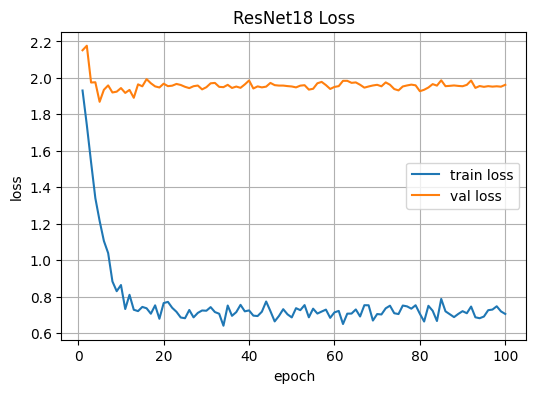

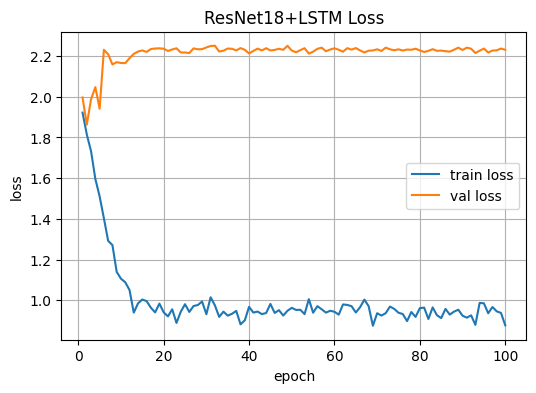

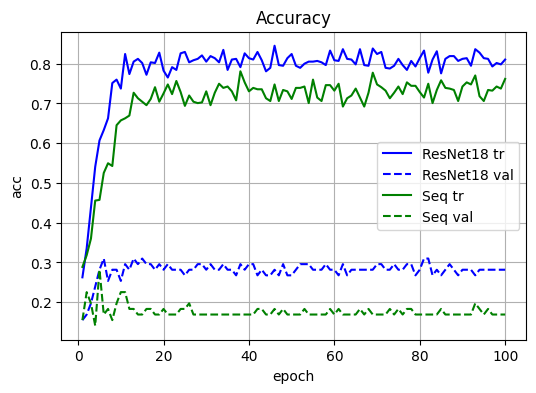

In [3]:
# ============================================================
#  MERGED CK+ & NEFER DVS → ResNet18 & LSTM transfer‐learning
# ============================================================

# ─── 0) CONFIG ─────────────────────────────────────────────
CSV_PATH     = "/kaggle/working/merged_dataset/dataset_manifest.csv"
IMG_PATTERN  = "dvs_frame_*.png"
BATCH_SIZE   = 32
SEQ_LEN      = 20
EPOCHS       = 100
LR           = 1e-4
VAL_SPLIT    = 0.1
WEIGHT_DECAY = 1e-5
STEP_SIZE    = 7
GAMMA        = 0.1
NUM_WORKERS  = 4

import os, glob, random, cv2
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ─── Device ───────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ─── 1) LOAD & FILTER THE MERGED MANIFEST ──────────────────
df = pd.read_csv(CSV_PATH)

# drop the 'unknown' emotion
df = df[df.emotion != "unknown"].reset_index(drop=True)

# rename to match the rest of your code
df = df.rename(columns={"folder":"events_folder"})

# helper: count number of frames in each folder
def count_frames(folder):
    pngs = glob.glob(os.path.join(folder, IMG_PATTERN))
    if pngs:
        return len(pngs)
    avi = os.path.join(folder, "dvs-video.avi")
    if os.path.isfile(avi):
        cap = cv2.VideoCapture(avi)
        cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return cnt
    return 0

df["nframes"] = df["events_folder"].apply(count_frames)
df = df[df["nframes"] > 0].reset_index(drop=True)
print(f"Kept {len(df)} sequences with ≥1 frame")

# ─── 2) SPLIT train/val/test ───────────────────────────────
random.seed(0); torch.manual_seed(0)
n     = len(df)
n_val = int(n * VAL_SPLIT)
perm  = np.random.permutation(n)

idx_val = perm[:n_val]
idx_test= perm[n_val:2*n_val]
idx_tr  = perm[2*n_val:]

train_df, val_df, test_df = df.iloc[idx_tr], df.iloc[idx_val], df.iloc[idx_test]
print("Splits →", len(train_df), "train,", len(val_df), "val,", len(test_df), "test")

# ─── 3) DATASET ─────────────────────────────────────────────
class DVSSequenceDataset(Dataset):
    def __init__(self, df, max_frames, pattern, tfm, mode="single"):
        self.df         = df.reset_index(drop=True)
        self.max_frames = max_frames
        self.pattern    = pattern
        self.tf         = tfm
        self.mode       = mode
        # label→int map
        self.lbl2id     = {l:i for i,l in enumerate(sorted(self.df["emotion"].unique()))}

    def __len__(self): 
        return len(self.df)

    def _load_frames(self, folder):
        # try PNGs first
        pngs = sorted(glob.glob(os.path.join(folder, self.pattern)))
        if pngs:
            return [Image.open(p).convert("L") for p in pngs]
        # else fallback to AVI
        cap, imgs = cv2.VideoCapture(os.path.join(folder, "dvs-video.avi")), []
        ret, frame = cap.read()
        while ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            imgs.append(Image.fromarray(gray))
            ret, frame = cap.read()
        cap.release()
        return imgs

    def __getitem__(self, idx):
        row    = self.df.iloc[idx]
        frames = self._load_frames(row.events_folder)

        if self.mode == "single":
            # pick the densest frame (most nonzeros)
            densest = max(frames, key=lambda im: np.array(im).sum())
            return self.tf(densest), self.lbl2id[row.emotion]

        # sequence mode
        seq = frames[:self.max_frames]
        # pad by repeating last
        while len(seq) < self.max_frames:
            seq.append(seq[-1])
        seq_t = torch.stack([self.tf(im) for im in seq], dim=0)  # [T,1,H,W]
        return seq_t, self.lbl2id[row.emotion]

# ─── 4) TRANSFORMS ─────────────────────────────────────────
train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

# ─── 5) DATALOADERS & SAMPLER ─────────────────────────────
# re‑balance on train set
counts         = train_df['emotion'].value_counts().sort_index()
class_weights  = 1.0 / counts
sample_weights = train_df['emotion'].map(class_weights).values
sampler        = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

single_train = DVSSequenceDataset(train_df, SEQ_LEN, IMG_PATTERN, train_tf,  "single")
single_val   = DVSSequenceDataset(val_df,   SEQ_LEN, IMG_PATTERN, val_tf,    "single")
single_test  = DVSSequenceDataset(test_df,  SEQ_LEN, IMG_PATTERN, val_tf,    "single")
seq_train    = DVSSequenceDataset(train_df, SEQ_LEN, IMG_PATTERN, train_tf,  "sequence")
seq_val      = DVSSequenceDataset(val_df,   SEQ_LEN, IMG_PATTERN, val_tf,    "sequence")

single_loader = {
    "train": DataLoader(single_train, BATCH_SIZE, sampler=sampler,     num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(single_val,   BATCH_SIZE, shuffle=False,      num_workers=NUM_WORKERS, pin_memory=True)
}
seq_loader = {
    "train": DataLoader(seq_train,    BATCH_SIZE, sampler=sampler,     num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(seq_val,      BATCH_SIZE, shuffle=False,      num_workers=NUM_WORKERS, pin_memory=True)
}

# ─── 6) MODEL A: ResNet‑18 single‑frame ─────────────────────
res = models.resnet18(pretrained=True)
w   = res.conv1.weight.data.clone()  # [64,3,7,7]
# adapt to 1‑channel
res.conv1 = nn.Conv2d(1,64,7,2,3,bias=False)
res.conv1.weight.data = w.mean(1,keepdim=True)
res.fc = nn.Linear(res.fc.in_features, len(single_train.lbl2id))
model_s = res.to(device)

# ─── 7) MODEL B: ResNet‑18 + LSTM ──────────────────────────
class ResLSTM(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        trunk = nn.Sequential(*list(backbone.children())[:-1])
        self.trunk = trunk
        self.lstm  = nn.LSTM(backbone.fc.in_features, 256, batch_first=True)
        self.head  = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: [B,T,1,224,224]
        B,T = x.shape[:2]
        feats = self.trunk(x.view(B*T,1,224,224)).view(B,T,-1)
        _,(h,_) = self.lstm(feats)
        return self.head(h.squeeze(0))

model_seq = ResLSTM(res, len(seq_train.lbl2id)).to(device)

# ─── 8) OPTIM & SCHED ──────────────────────────────────────
opt_s   = torch.optim.Adam(model_s.parameters(),   lr=LR, weight_decay=WEIGHT_DECAY)
opt_seq = torch.optim.Adam(model_seq.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sch_s   = torch.optim.lr_scheduler.StepLR(opt_s,   step_size=STEP_SIZE, gamma=GAMMA)
sch_seq = torch.optim.lr_scheduler.StepLR(opt_seq, step_size=STEP_SIZE, gamma=GAMMA)
crit    = nn.CrossEntropyLoss()

# ─── 9) TRAIN/VALID FUNCTION ─────────────────────────────
def train_model(model, loaders, optimizer, scheduler, name):
    history = {"epoch":[],"tr_loss":[],"tr_acc":[],"val_loss":[],"val_acc":[]}
    for ep in range(1, EPOCHS+1):
        for phase in ("train","val"):
            model.train(phase=="train")
            running_loss=running_corr=running_n=0
            with torch.set_grad_enabled(phase=="train"):
                for X,y in loaders[phase]:
                    X,y = X.to(device), y.to(device)
                    if phase=="train": optimizer.zero_grad()
                    out = model(X)
                    loss= crit(out,y)
                    if phase=="train": loss.backward(); optimizer.step()
                    preds = out.argmax(1)
                    running_loss += loss.item()*y.size(0)
                    running_corr += (preds==y).sum().item()
                    running_n    += y.size(0)
            avg_loss = running_loss/running_n
            avg_acc  = running_corr/running_n
            history[f"{'tr' if phase=='train' else 'val'}_loss"].append(avg_loss)
            history[f"{'tr' if phase=='train' else 'val'}_acc"].append(avg_acc)
        scheduler.step()
        history["epoch"].append(ep)
        print(f"[{name}] Ep{ep}/{EPOCHS}  tr_acc {history['tr_acc'][-1]:.3f}  val_acc {history['val_acc'][-1]:.3f}")
    return history

# ─── 10) TRAIN ─────────────────────────────────────────────
hist_s   = train_model(model_s,   single_loader, opt_s,   sch_s,   "ResNet18")
hist_seq = train_model(model_seq,  seq_loader,    opt_seq, sch_seq, "ResNet18+LSTM")

# ─── 11) EVAL & METRICS ────────────────────────────────────
def evaluate(model, loader, seq=False):
    model.eval(); yt,yp = [],[]
    with torch.no_grad():
        for X,y in loader:
            if not seq: 
                # single‐frame: pick densest
                pass
            out = model(X.to(device))
            yt += y.tolist()
            yp += out.argmax(1).cpu().tolist()
    acc      = accuracy_score(yt,yp)
    prec,rc,f1,_ = precision_recall_fscore_support(
        yt,yp,average="weighted",zero_division=0)
    return acc,prec,rc,f1

m_s   = evaluate(model_s,   DataLoader(single_test, BATCH_SIZE, shuffle=False), seq=False)
m_seq = evaluate(model_seq, DataLoader(seq_train,    BATCH_SIZE, shuffle=False), seq=True)
print(f"\nSingle ResNet18 — acc {m_s[0]:.3f} prec {m_s[1]:.3f} rec {m_s[2]:.3f} f1 {m_s[3]:.3f}")
print(f"Seq ResNet18+LSTM — acc {m_seq[0]:.3f} prec {m_seq[1]:.3f} rec {m_seq[2]:.3f} f1 {m_seq[3]:.3f}")

# ─── 12) PLOTTING ──────────────────────────────────────────
def plot_curves(h, title):
    plt.figure(figsize=(6,4))
    plt.plot(h["epoch"], h["tr_loss"], label="train loss")
    plt.plot(h["epoch"], h["val_loss"], label="val loss")
    plt.title(f"{title} Loss"); plt.xlabel("epoch"); plt.ylabel("loss")
    plt.legend(); plt.grid(True); plt.show()

plot_curves(hist_s,   "ResNet18")
plot_curves(hist_seq, "ResNet18+LSTM")

plt.figure(figsize=(6,4))
plt.plot(hist_s["epoch"],   hist_s["tr_acc"],   "b-",  label="ResNet18 tr")
plt.plot(hist_s["epoch"],   hist_s["val_acc"],  "b--", label="ResNet18 val")
plt.plot(hist_seq["epoch"], hist_seq["tr_acc"], "g-",  label="Seq tr")
plt.plot(hist_seq["epoch"], hist_seq["val_acc"],"g--", label="Seq val")
plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc")
plt.legend(); plt.grid(True); plt.show()


In [8]:
save_path = "/kaggle/working/resnet2_transformer_ckpt.pth"
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': opt.state_dict(),
    'scheduler_state_dict': sched.state_dict(),
    'label_map': all_em,    # list of class names in order
}, save_path)
print(f"✅ Saved checkpoint to {save_path}")

✅ Saved checkpoint to /kaggle/working/resnet_transformer_ckpt.pth
